In [1]:
!pip install medmnist

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [6]:
data_flag = 'chestmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

variables_to_print = {
    'data_flag': data_flag,
    'download': download,
    'NUM_EPOCHS': NUM_EPOCHS,
    'BATCH_SIZE': BATCH_SIZE,
    'lr': lr,
    'task': task,
    'n_channels': n_channels,
    'n_classes': n_classes,
    'DataClass': DataClass
}

for var_name, var_value in variables_to_print.items():
    print(f"{var_name}: {var_value}")


data_flag: chestmnist
download: True
NUM_EPOCHS: 3
BATCH_SIZE: 128
lr: 0.001
task: multi-label, binary-class
n_channels: 1
n_classes: 14
DataClass: <class 'medmnist.dataset.ChestMNIST'>


In [8]:
from torch.utils.data import DataLoader

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
pil_dataset = DataClass(split='train', download=download)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

variables_to_print_data = {
    'data_transform': data_transform,
    'train_dataset': train_dataset,
    'test_dataset': test_dataset,
    'pil_dataset': pil_dataset,
    'train_loader': train_loader,
    'train_loader_at_eval': train_loader_at_eval,
    'test_loader': test_loader
}

for var_name, var_value in variables_to_print_data.items():
    print(f"{var_name}: {var_value}")


Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
data_transform: Compose(
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)
train_dataset: Dataset ChestMNIST of size 28 (chestmnist)
    Number of datapoints: 78468
    Root location: C:\Users\Ashraf\.medmnist
    Split: train
    Task: multi-label, binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
    Number of samples: {'train': 78468, 'val': 11219, 'test': 22433}
    Description: The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 

In [9]:
train_dataset.montage(length=1)

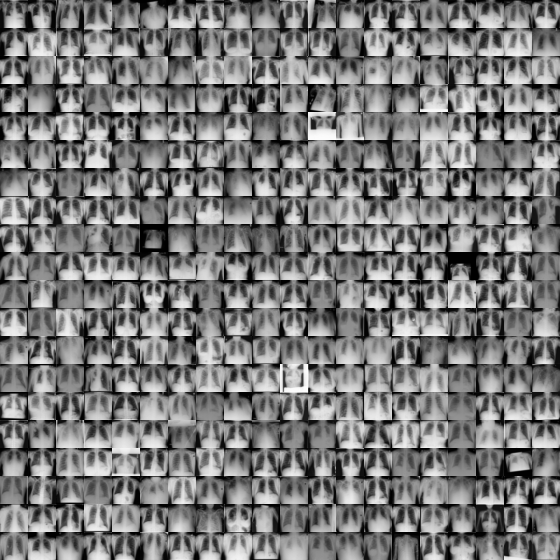

In [10]:
train_dataset.montage(length=20)

In [145]:
# Resnet 18
torch.cuda.empty_cache()

Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Epoch 1/5, Train Loss: 0.1767, Train Acc: 94.83%, Test Loss: 0.2738, Test Acc: 94.74%
Epoch 2/5, Train Loss: 0.1692, Train Acc: 94.86%, Test Loss: 0.1702, Test Acc: 94.74%
Epoch 3/5, Train Loss: 0.1640, Train Acc: 94.88%, Test Loss: 0.2696, Test Acc: 94.78%
Epoch 4/5, Train Loss: 0.1608, Train Acc: 94.89%, Test Loss: 0.2160, Test Acc: 94.74%
Epoch 5/5, Train Loss: 0.1582, Train Acc: 94.91%, Test Loss: 0.1704, Test Acc: 94.77%


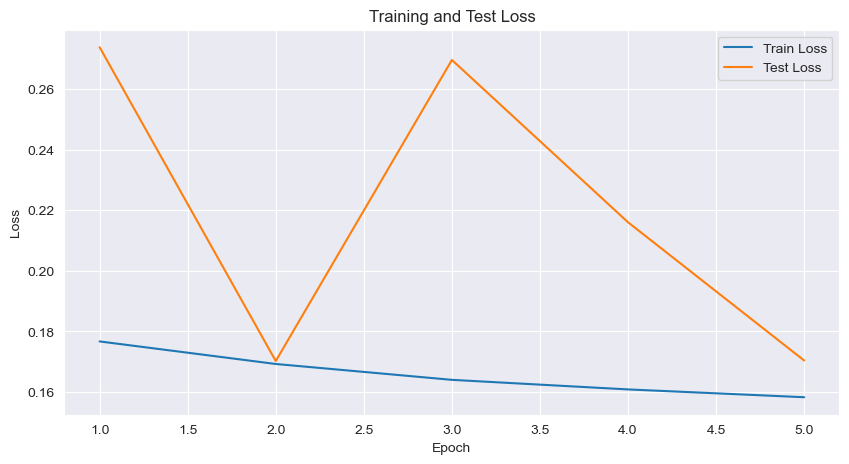

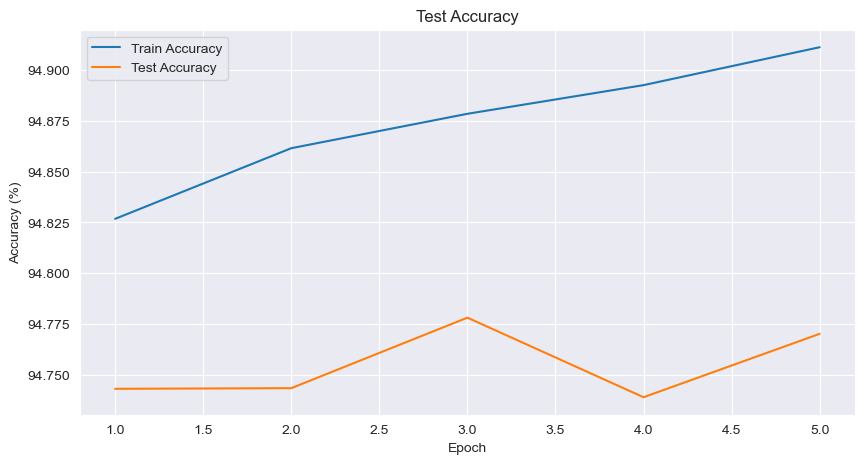

In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from medmnist import ChestMNIST
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

size = 28

train_dataset = ChestMNIST(split="train", download=True, size=size, transform=transform)
val_dataset = ChestMNIST(split="val", download=True, size=size, transform=transform)
test_dataset = ChestMNIST(split="test", download=True, size=size, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) 

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 14) 

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0  
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())  
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        predicted_train = (torch.sigmoid(outputs) > 0.5).int()
        total_train += labels.size(0) * labels.size(1)  
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = (correct_train / total_train) * 100
    train_accuracies.append(train_accuracy)
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).int()
            total += labels.size(0) * labels.size(1)  
            correct += (predicted == labels).sum().item()

        test_accuracy = (correct / total) * 100
        test_loss = criterion(outputs, labels.float()).item()
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.show()

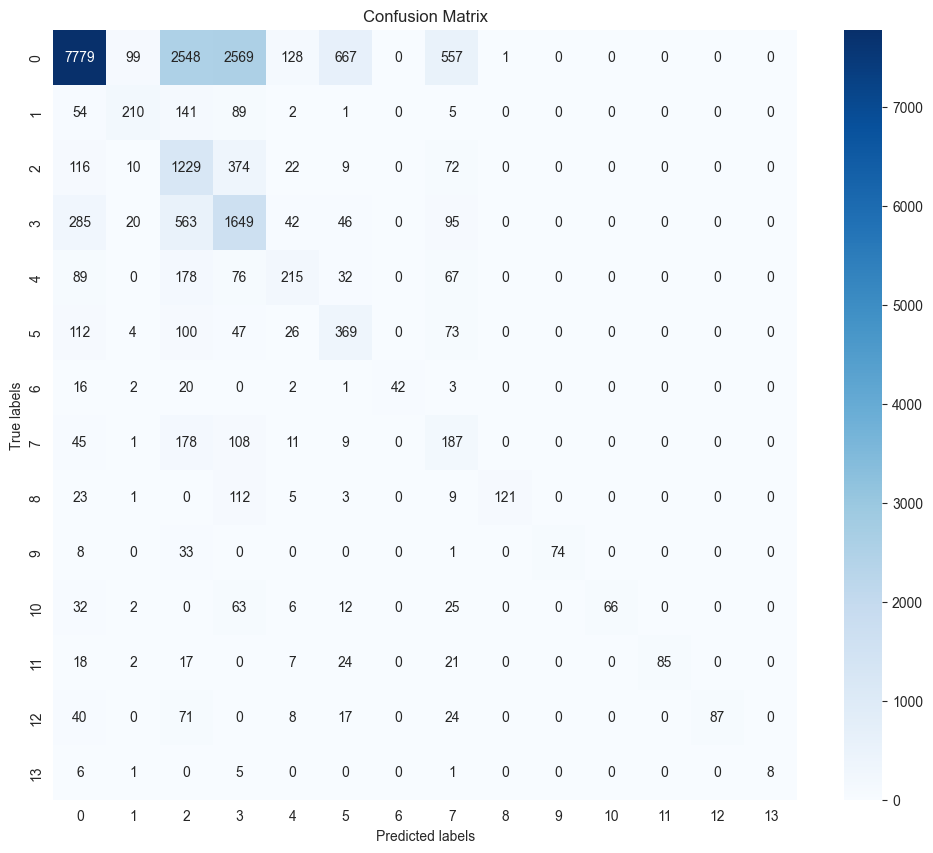

In [6]:
conf_matrix = np.zeros((14, 14), dtype=int)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1) 
        for i in range(len(labels)):
            conf_matrix[labels[i]][predicted[i]] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

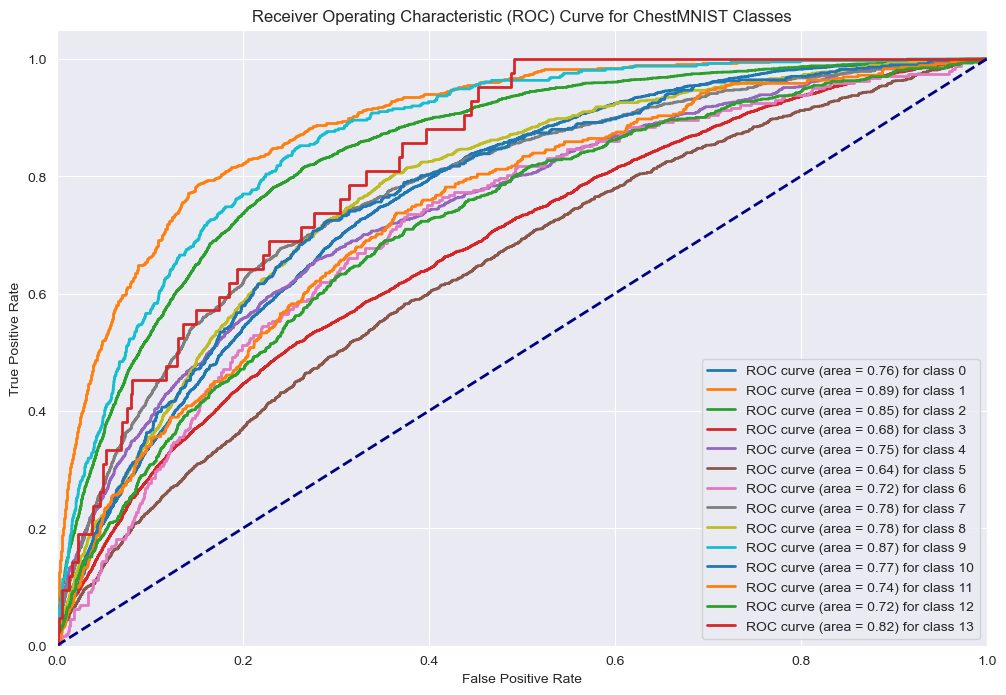

In [150]:
tprs = []
fprs = []

plt.figure(figsize=(12, 8))
for i in range(14):
    y_true = []
    y_scores = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted_probs = torch.sigmoid(outputs)
            y_true.extend(labels[:, i].tolist())
            y_scores.extend(predicted_probs[:, i].tolist())
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc, i))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for ChestMNIST Classes')
plt.legend(loc="lower right")
plt.show()

In [153]:
# Resnet 50
torch.cuda.empty_cache()

Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Epoch 1/5, Train Loss: 0.1803, Train Acc: 94.83%, Test Loss: 0.2526, Test Acc: 94.74%
Epoch 2/5, Train Loss: 0.1751, Train Acc: 94.85%, Test Loss: 0.2450, Test Acc: 94.75%
Epoch 3/5, Train Loss: 0.1717, Train Acc: 94.85%, Test Loss: 0.2159, Test Acc: 94.74%
Epoch 4/5, Train Loss: 0.1686, Train Acc: 94.87%, Test Loss: 0.1885, Test Acc: 94.76%
Epoch 5/5, Train Loss: 0.1658, Train Acc: 94.87%, Test Loss: 0.2229, Test Acc: 94.77%


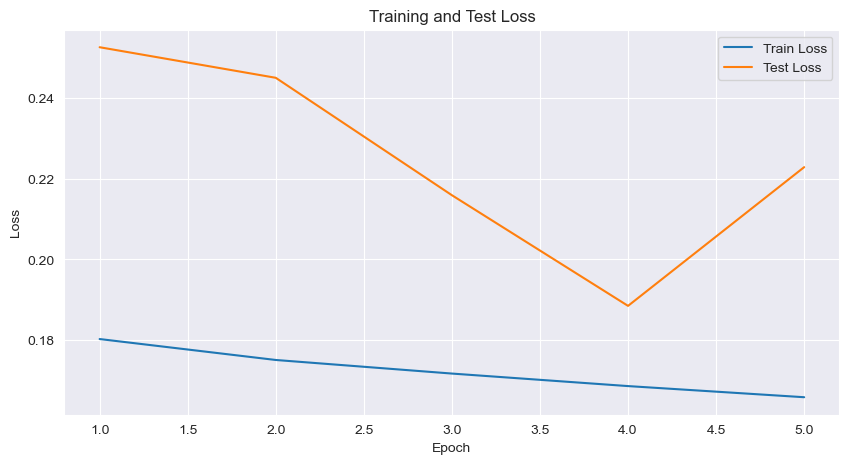

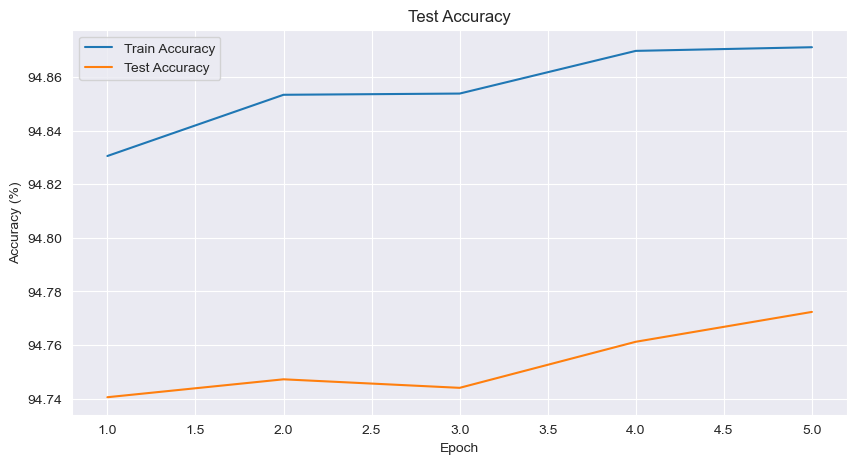

In [154]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from medmnist import ChestMNIST
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

size = 28

train_dataset = ChestMNIST(split="train", download=True, size=size, transform=transform)
val_dataset = ChestMNIST(split="val", download=True, size=size, transform=transform)
test_dataset = ChestMNIST(split="test", download=True, size=size, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = resnet50(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) 

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 14)  

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0  
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float()) 
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        predicted_train = (torch.sigmoid(outputs) > 0.5).int()
        total_train += labels.size(0) * labels.size(1)  
        correct_train += (predicted_train == labels).sum().item()
    train_accuracy = (correct_train / total_train) * 100
    train_accuracies.append(train_accuracy)
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).int()
            total += labels.size(0) * labels.size(1) 
            correct += (predicted == labels).sum().item()

        test_accuracy = (correct / total) * 100
        test_loss = criterion(outputs, labels.float()).item()
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.show()

In [155]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_labels = []
all_predicted = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).int()

        all_labels.append(labels.cpu().numpy())
        all_predicted.append(predicted.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_predicted = np.concatenate(all_predicted)

all_labels_flat = all_labels.flatten()
all_predicted_flat = all_predicted.flatten()

precision = precision_score(all_labels_flat, all_predicted_flat, average='weighted')
recall = recall_score(all_labels_flat, all_predicted_flat, average='weighted')
f1 = f1_score(all_labels_flat, all_predicted_flat, average='weighted')

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.9298, Recall: 0.9477, F1-score: 0.9237


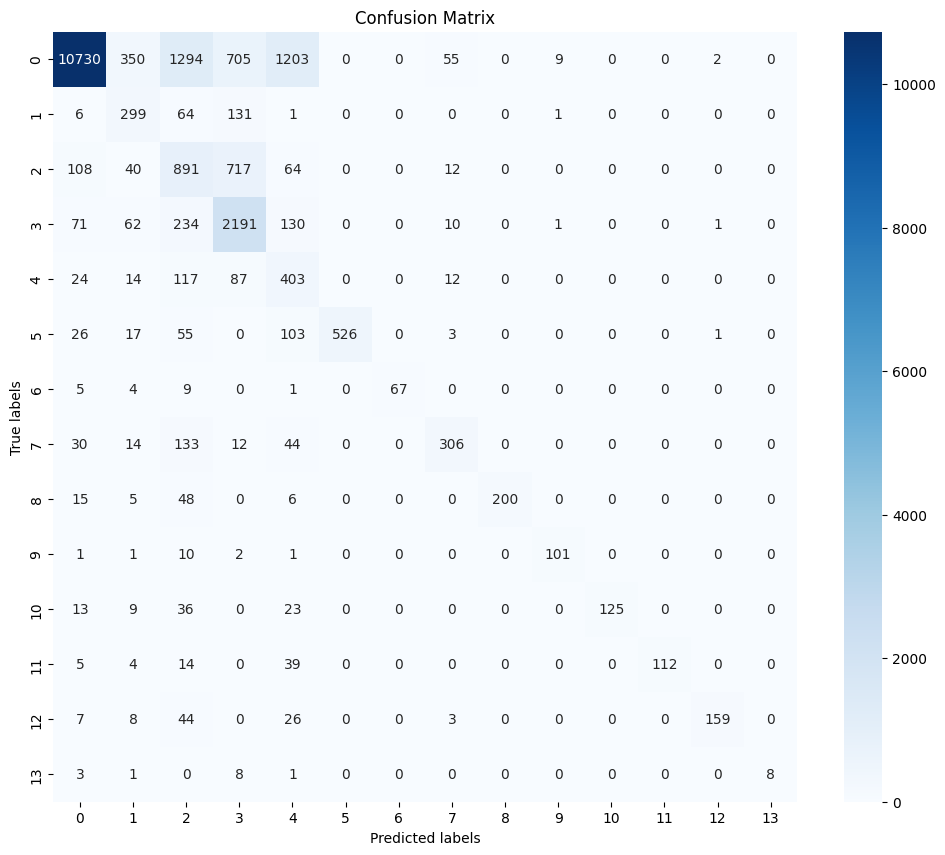

In [3]:
conf_matrix = np.zeros((14, 14), dtype=int)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1) 
        for i in range(len(labels)):
            conf_matrix[labels[i]][predicted[i]] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

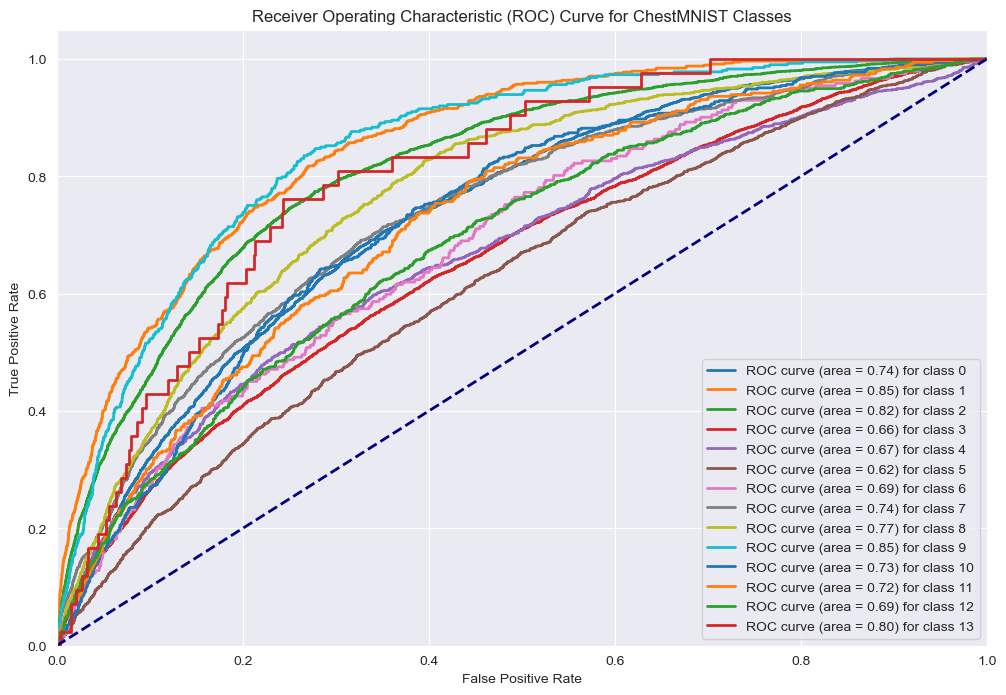

In [158]:
tprs = []
fprs = []

plt.figure(figsize=(12, 8))
for i in range(14):
    y_true = []
    y_scores = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted_probs = torch.sigmoid(outputs)
            y_true.extend(labels[:, i].tolist())
            y_scores.extend(predicted_probs[:, i].tolist())
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc, i))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for ChestMNIST Classes')
plt.legend(loc="lower right")
plt.show()

In [159]:
# Densenet 121
torch.cuda.empty_cache()

Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz


C:\Users\Ashraf\anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ashraf\anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.1770, Train Acc: 94.82%, Test Loss: 0.2273, Test Acc: 94.75%
Epoch 2/5, Train Loss: 0.1719, Train Acc: 94.86%, Test Loss: 0.2294, Test Acc: 94.75%
Epoch 3/5, Train Loss: 0.1683, Train Acc: 94.86%, Test Loss: 0.2116, Test Acc: 94.77%
Epoch 4/5, Train Loss: 0.1643, Train Acc: 94.88%, Test Loss: 0.2283, Test Acc: 94.78%
Epoch 5/5, Train Loss: 0.1613, Train Acc: 94.90%, Test Loss: 0.2602, Test Acc: 94.80%


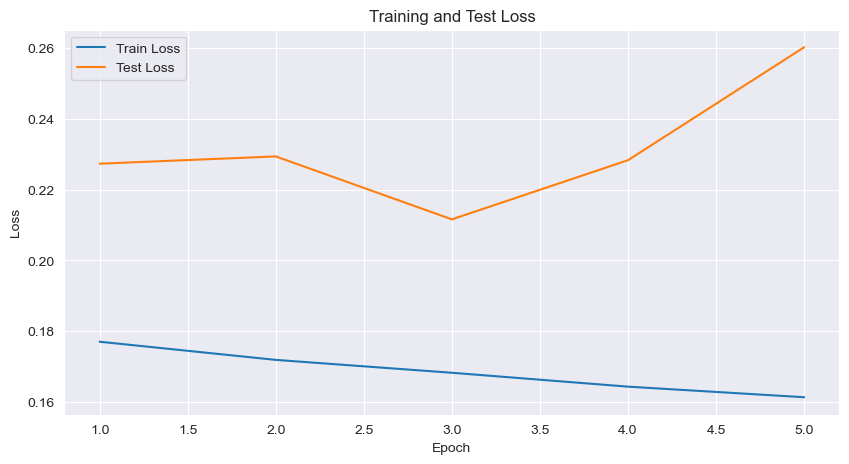

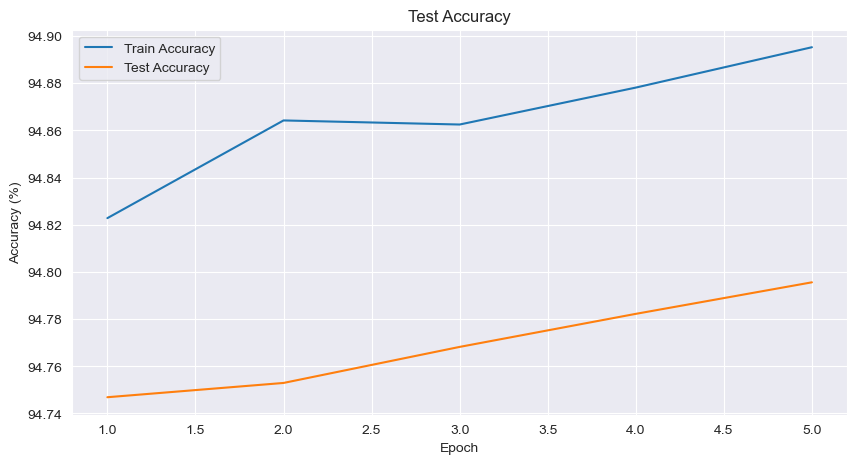

In [160]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import densenet121
from medmnist import ChestMNIST
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

size = 28

train_dataset = ChestMNIST(split="train", download=True, size=size, transform=transform)
val_dataset = ChestMNIST(split="val", download=True, size=size, transform=transform)
test_dataset = ChestMNIST(split="test", download=True, size=size, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = densenet121(pretrained=False)
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 14) 

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0  
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())  
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        predicted_train = (torch.sigmoid(outputs) > 0.5).int()
        total_train += labels.size(0) * labels.size(1)  
        correct_train += (predicted_train == labels).sum().item()
    train_accuracy = (correct_train / total_train) * 100
    train_accuracies.append(train_accuracy)
    train_losses.append(running_loss / len(train_loader))

    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            predicted = (torch.sigmoid(outputs) > 0.5).int()
            total += labels.size(0) * labels.size(1)  
            correct += (predicted == labels).sum().item()

        test_accuracy = (correct / total) * 100
        test_loss = criterion(outputs, labels.float()).item()
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.show()

In [161]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_labels = []
all_predicted = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        predicted = (torch.sigmoid(outputs) > 0.5).int()

        
        all_labels.append(labels.cpu().numpy())
        all_predicted.append(predicted.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_predicted = np.concatenate(all_predicted)

all_labels_flat = all_labels.flatten()
all_predicted_flat = all_predicted.flatten()

precision = precision_score(all_labels_flat, all_predicted_flat, average='weighted')
recall = recall_score(all_labels_flat, all_predicted_flat, average='weighted')
f1 = f1_score(all_labels_flat, all_predicted_flat, average='weighted')

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.9293, Recall: 0.9480, F1-score: 0.9264


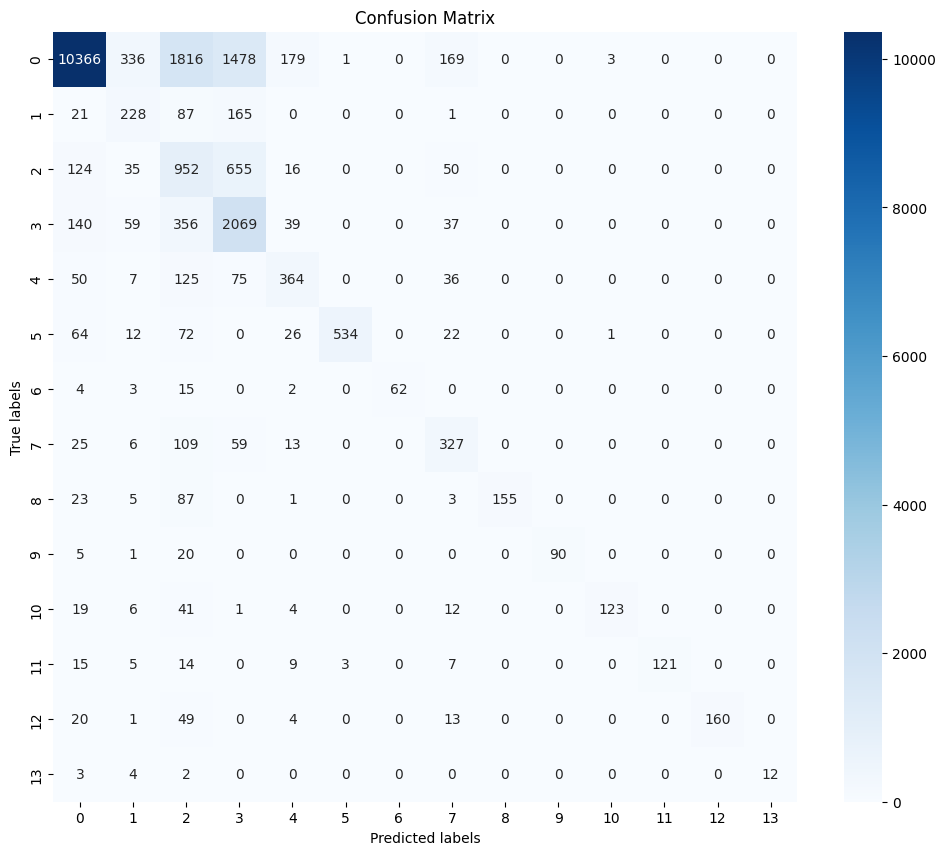

In [4]:
conf_matrix = np.zeros((14, 14), dtype=int)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)  
        for i in range(len(labels)):
            conf_matrix[labels[i]][predicted[i]] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

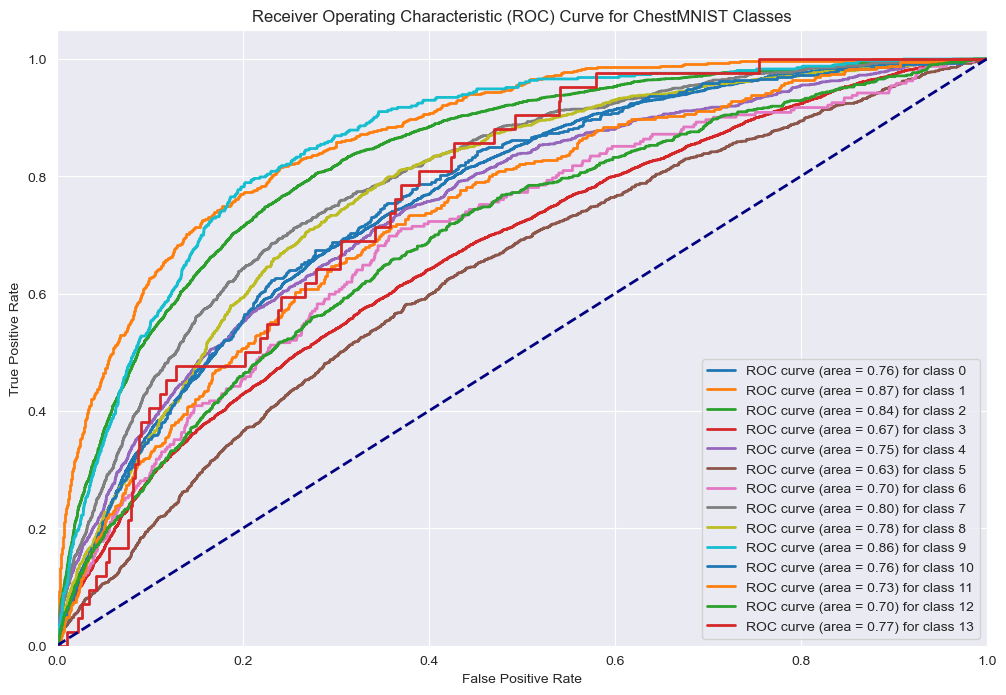

In [164]:
tprs = []
fprs = []

plt.figure(figsize=(12, 8))
for i in range(14):
    y_true = []
    y_scores = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted_probs = torch.sigmoid(outputs)
            y_true.extend(labels[:, i].tolist())
            y_scores.extend(predicted_probs[:, i].tolist())
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc, i))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for ChestMNIST Classes')
plt.legend(loc="lower right")
plt.show()


In [165]:
# ResNext
torch.cuda.empty_cache()

Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz


C:\Users\Ashraf\anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ashraf\anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.1783, Train Acc: 94.83%, Test Loss: 0.2768, Test Acc: 94.69%
Epoch 2/5, Train Loss: 0.1727, Train Acc: 94.85%, Test Loss: 0.2530, Test Acc: 94.69%
Epoch 3/5, Train Loss: 0.1693, Train Acc: 94.86%, Test Loss: 0.2283, Test Acc: 94.76%
Epoch 4/5, Train Loss: 0.1659, Train Acc: 94.87%, Test Loss: 0.1885, Test Acc: 94.78%
Epoch 5/5, Train Loss: 0.1628, Train Acc: 94.89%, Test Loss: 0.1949, Test Acc: 94.79%


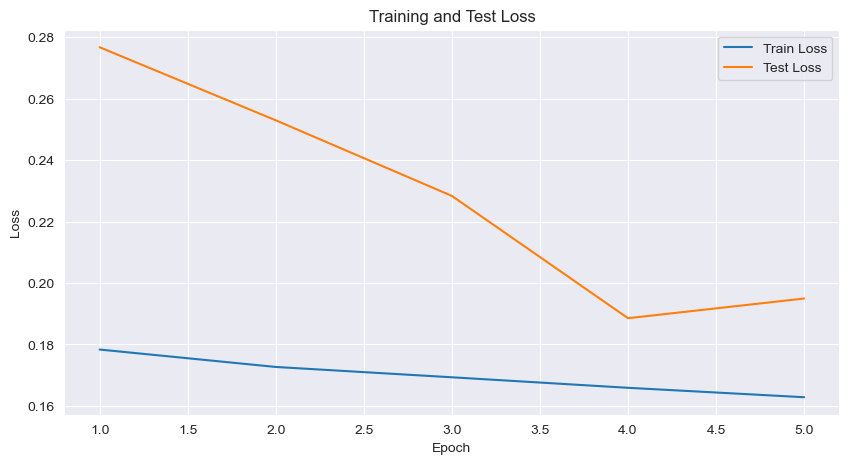

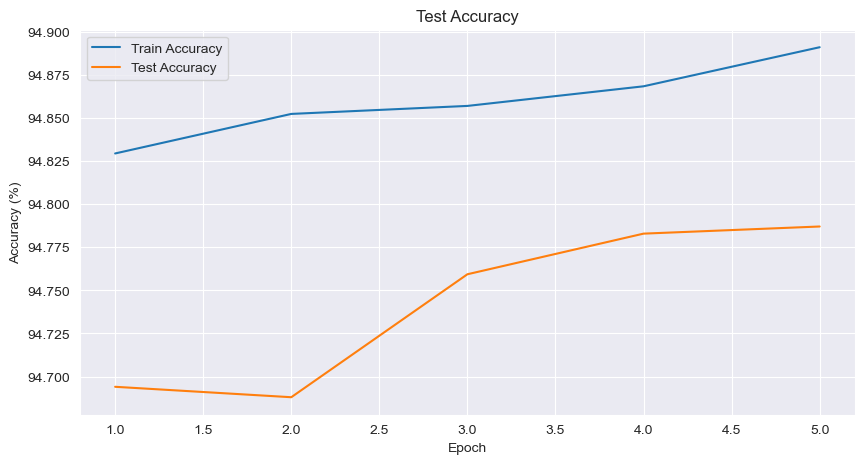

In [166]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnext50_32x4d  
from medmnist import ChestMNIST
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

size = 28

train_dataset = ChestMNIST(split="train", download=True, size=size, transform=transform)
val_dataset = ChestMNIST(split="val", download=True, size=size, transform=transform)
test_dataset = ChestMNIST(split="test", download=True, size=size, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = resnext50_32x4d(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 14)  

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0  
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())  
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        predicted_train = (torch.sigmoid(outputs) > 0.5).int()
        total_train += labels.size(0) * labels.size(1)  
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = (correct_train / total_train) * 100
    train_accuracies.append(train_accuracy)
    train_losses.append(running_loss / len(train_loader))

    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            predicted = (torch.sigmoid(outputs) > 0.5).int()
            total += labels.size(0) * labels.size(1)  
            correct += (predicted == labels).sum().item()

        test_accuracy = (correct / total) * 100
        test_loss = criterion(outputs, labels.float()).item()
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.show()

In [167]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_labels = []
all_predicted = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        predicted = (torch.sigmoid(outputs) > 0.5).int()

        
        all_labels.append(labels.cpu().numpy())
        all_predicted.append(predicted.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_predicted = np.concatenate(all_predicted)

all_labels_flat = all_labels.flatten()
all_predicted_flat = all_predicted.flatten()

precision = precision_score(all_labels_flat, all_predicted_flat, average='weighted')
recall = recall_score(all_labels_flat, all_predicted_flat, average='weighted')
f1 = f1_score(all_labels_flat, all_predicted_flat, average='weighted')

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.9326, Recall: 0.9479, F1-score: 0.9239


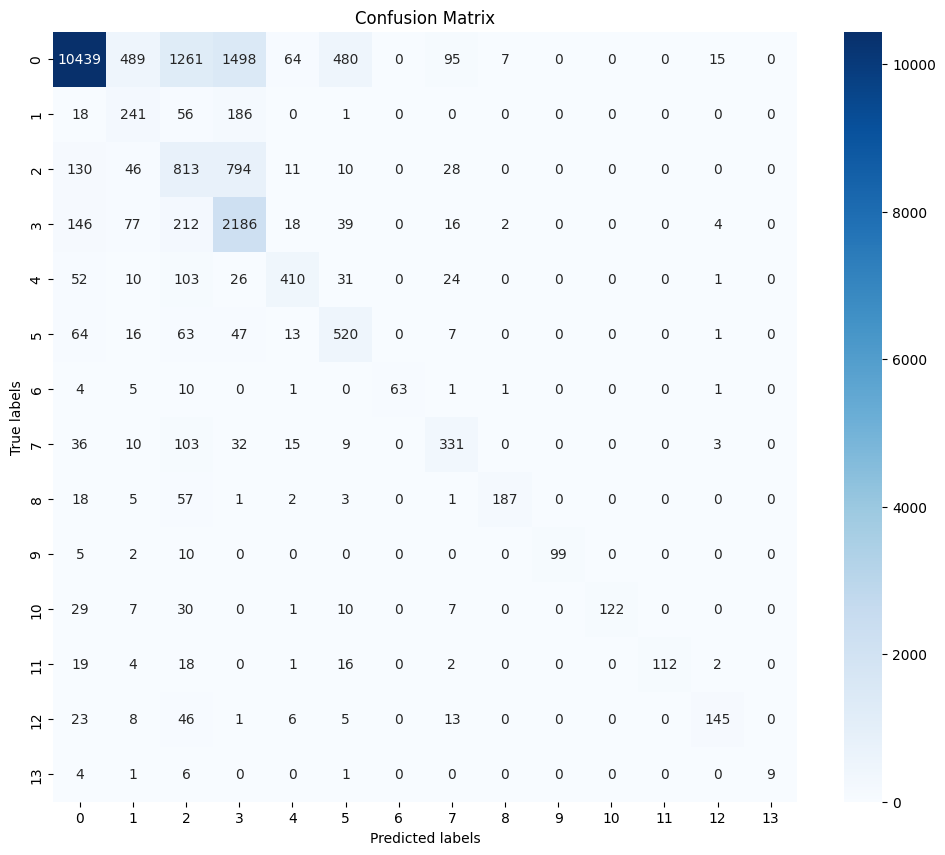

In [5]:
conf_matrix = np.zeros((14, 14), dtype=int)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)  
        for i in range(len(labels)):
            conf_matrix[labels[i]][predicted[i]] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

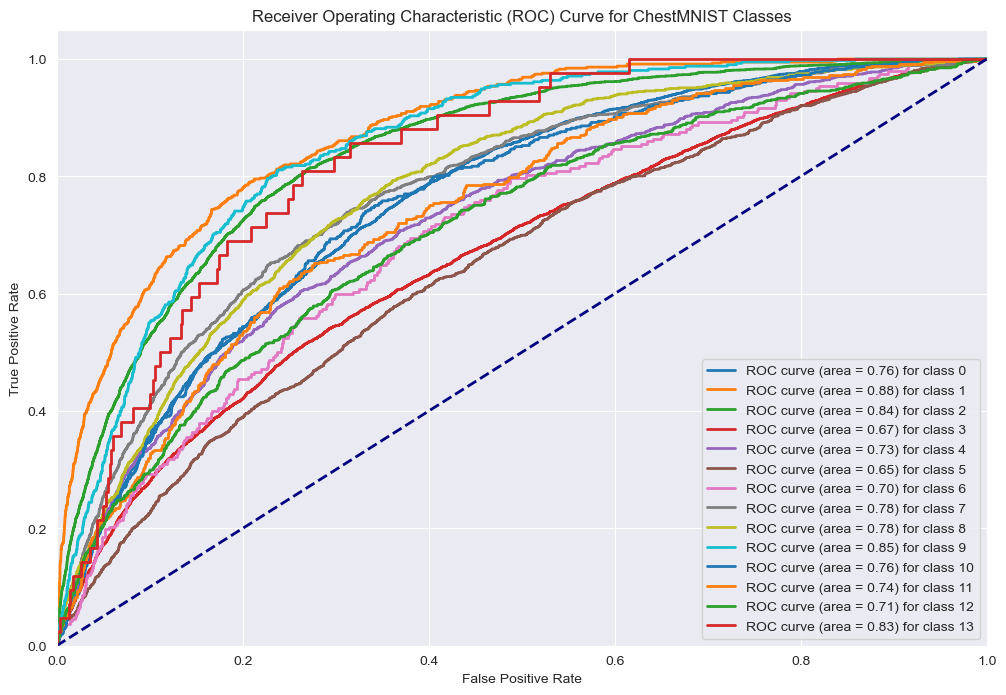

In [170]:
tprs = []
fprs = []

plt.figure(figsize=(12, 8))
for i in range(14):
    y_true = []
    y_scores = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted_probs = torch.sigmoid(outputs)
            y_true.extend(labels[:, i].tolist())
            y_scores.extend(predicted_probs[:, i].tolist())
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc, i))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for ChestMNIST Classes')
plt.legend(loc="lower right")
plt.show()

In [171]:
# Googlenet
torch.cuda.empty_cache()

Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz


C:\Users\Ashraf\anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ashraf\anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Ashraf\anaconda3\envs\gpu\lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoch 1/5, Train Loss: 0.1780, Train Acc: 94.84%, Test Loss: 0.2347, Test Acc: 94.74%
Epoch 2/5, Train Loss: 0.1730, Train Acc: 94.86%, Test Loss: 0.2188, Test Acc: 94.75%
Epoch 3/5, Train Loss: 0.1702, Train Acc: 94.86%, Test Loss: 0.2313, Test Acc: 94.75%
Epoch 4/5, Train Loss: 0.1672, Train Acc: 94.87%, Test Loss: 0.2005, Test Acc: 94.67%
Epoch 5/5, Train Loss: 0.1648, Train Acc: 94.88%, Test Loss: 0.1902, Test Acc: 94.71%


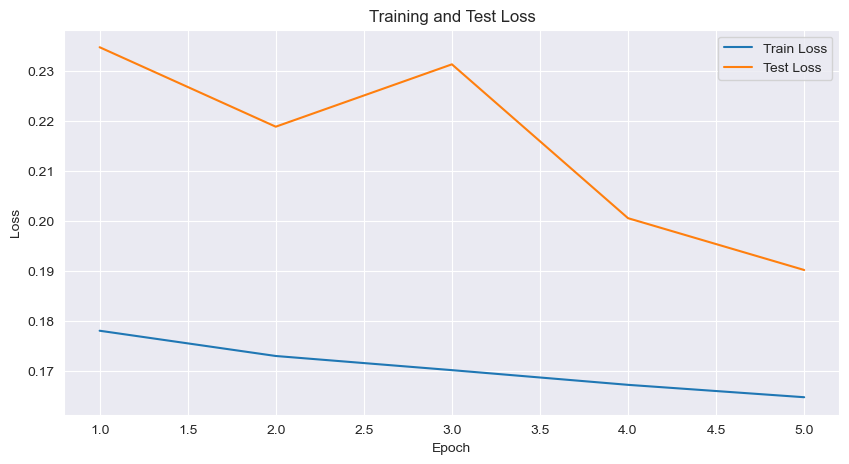

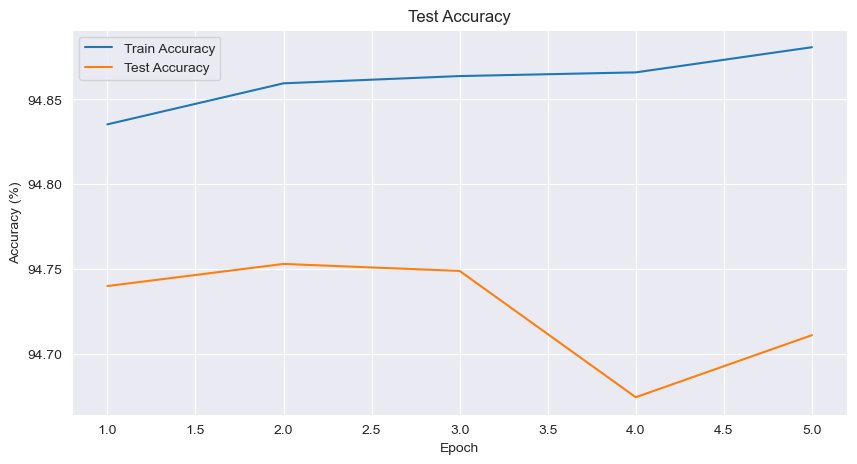

In [172]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import googlenet
from medmnist import ChestMNIST
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

size = 28

train_dataset = ChestMNIST(split="train", download=True, size=size, transform=transform)
val_dataset = ChestMNIST(split="val", download=True, size=size, transform=transform)
test_dataset = ChestMNIST(split="test", download=True, size=size, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = googlenet(pretrained=False, aux_logits=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 14)  

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0  
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())  
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        predicted_train = (torch.sigmoid(outputs) > 0.5).int()
        total_train += labels.size(0) * labels.size(1)  
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = (correct_train / total_train) * 100
    train_accuracies.append(train_accuracy)
    train_losses.append(running_loss / len(train_loader))

    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            predicted = (torch.sigmoid(outputs) > 0.5).int()
            total += labels.size(0) * labels.size(1)  
            correct += (predicted == labels).sum().item()

        test_accuracy = (correct / total) * 100
        test_loss = criterion(outputs, labels.float()).item()
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.show()

In [173]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_labels = []
all_predicted = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        predicted = (torch.sigmoid(outputs) > 0.5).int()

        
        all_labels.append(labels.cpu().numpy())
        all_predicted.append(predicted.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_predicted = np.concatenate(all_predicted)

all_labels_flat = all_labels.flatten()
all_predicted_flat = all_predicted.flatten()

precision = precision_score(all_labels_flat, all_predicted_flat, average='weighted')
recall = recall_score(all_labels_flat, all_predicted_flat, average='weighted')
f1 = f1_score(all_labels_flat, all_predicted_flat, average='weighted')

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.9255, Recall: 0.9471, F1-score: 0.9274


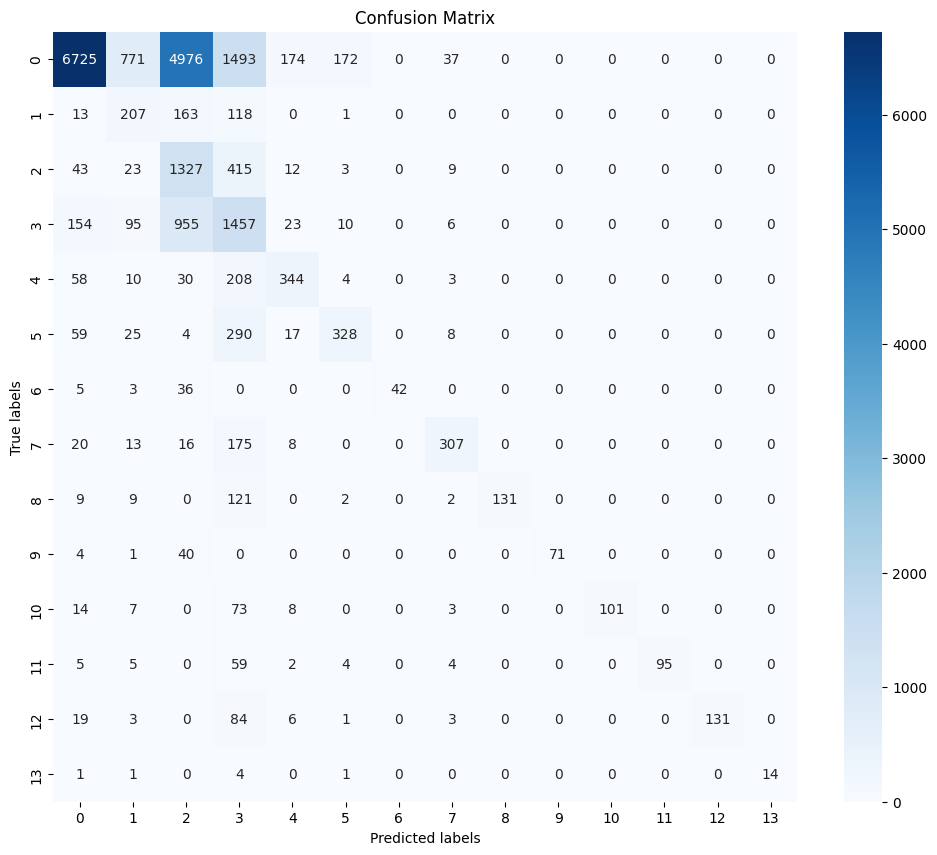

In [6]:
conf_matrix = np.zeros((14, 14), dtype=int)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)  
        for i in range(len(labels)):
            conf_matrix[labels[i]][predicted[i]] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

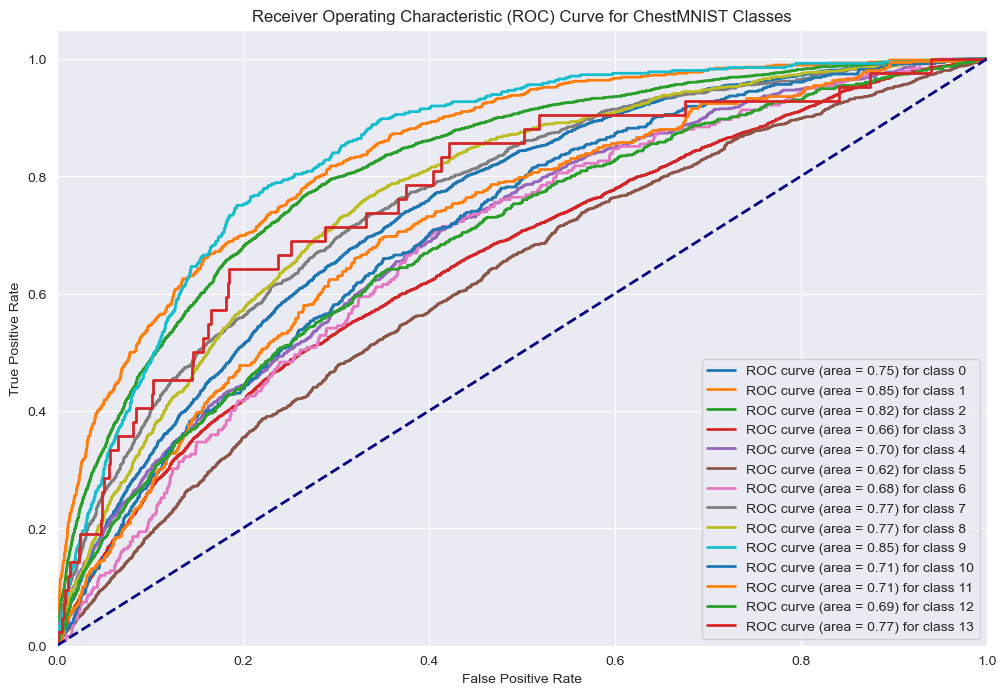

In [176]:
tprs = []
fprs = []

plt.figure(figsize=(12, 8))
for i in range(14):
    y_true = []
    y_scores = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted_probs = torch.sigmoid(outputs)
            y_true.extend(labels[:, i].tolist())
            y_scores.extend(predicted_probs[:, i].tolist())
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc, i))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for ChestMNIST Classes')
plt.legend(loc="lower right")
plt.show()

In [171]:
# VGG16
torch.cuda.empty_cache()

Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Ashraf\.medmnist\chestmnist.npz


C:\Users\Ashraf\anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ashraf\anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.2203, Train Acc: 94.81%, Test Loss: 0.2698, Test Acc: 94.74%
Epoch 2/5, Train Loss: 0.1837, Train Acc: 94.86%, Test Loss: 0.2703, Test Acc: 94.74%
Epoch 3/5, Train Loss: 0.1835, Train Acc: 94.86%, Test Loss: 0.2771, Test Acc: 94.74%
Epoch 4/5, Train Loss: 0.1834, Train Acc: 94.86%, Test Loss: 0.2617, Test Acc: 94.74%
Epoch 5/5, Train Loss: 0.1835, Train Acc: 94.86%, Test Loss: 0.2765, Test Acc: 94.74%


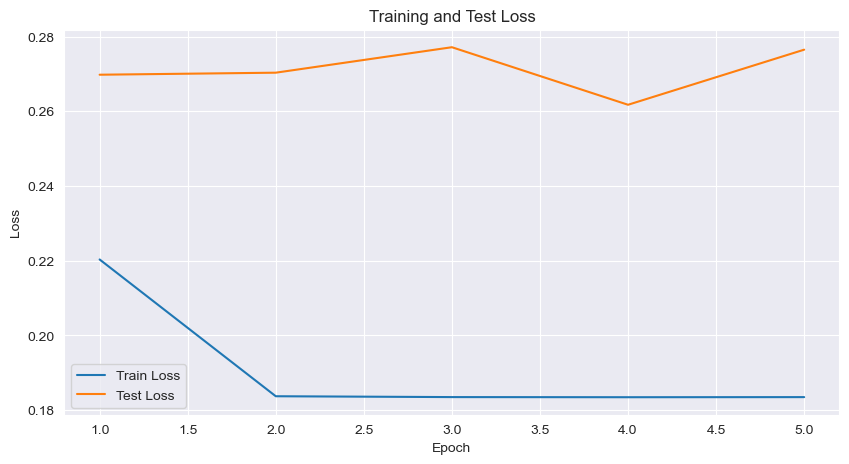

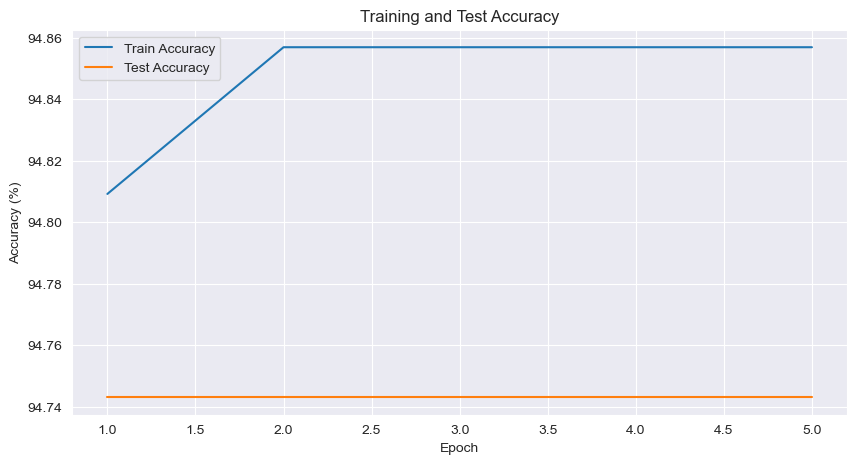

In [181]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import vgg16  
from medmnist import ChestMNIST
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

size = 28

train_dataset = ChestMNIST(split="train", download=True, size=size, transform=transform)
val_dataset = ChestMNIST(split="val", download=True, size=size, transform=transform)
test_dataset = ChestMNIST(split="test", download=True, size=size, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = vgg16(pretrained=False)
model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  
num_features = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 14),  
)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())  
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        predicted_train = (torch.sigmoid(outputs) > 0.5).int()
        total_train += labels.size(0) * labels.size(1)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = (correct_train / total_train) * 100
    train_accuracies.append(train_accuracy)
    train_losses.append(running_loss / len(train_loader))

    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).int()
            total += labels.size(0) * labels.size(1)
            correct += (predicted == labels).sum().item()

        test_accuracy = (correct / total) * 100
        test_loss = criterion(outputs, labels.float()).item()
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

In [182]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_labels = []
all_predicted = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        predicted = (torch.sigmoid(outputs) > 0.5).int()

        
        all_labels.append(labels.cpu().numpy())
        all_predicted.append(predicted.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_predicted = np.concatenate(all_predicted)

all_labels_flat = all_labels.flatten()
all_predicted_flat = all_predicted.flatten()

precision = precision_score(all_labels_flat, all_predicted_flat, average='weighted')
recall = recall_score(all_labels_flat, all_predicted_flat, average='weighted')
f1 = f1_score(all_labels_flat, all_predicted_flat, average='weighted')

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.8976, Recall: 0.9474, F1-score: 0.9219


C:\Users\Ashraf\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


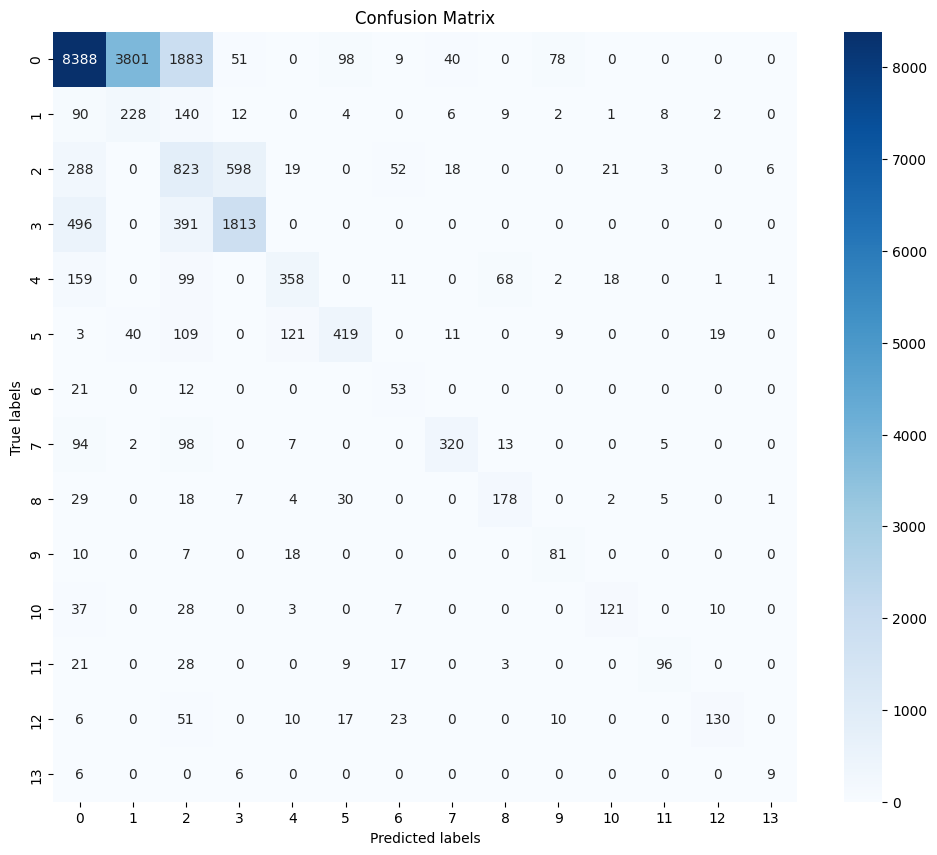

In [10]:
conf_matrix = np.zeros((14, 14), dtype=int)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)  
        for i in range(len(labels)):
            conf_matrix[labels[i]][predicted[i]] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

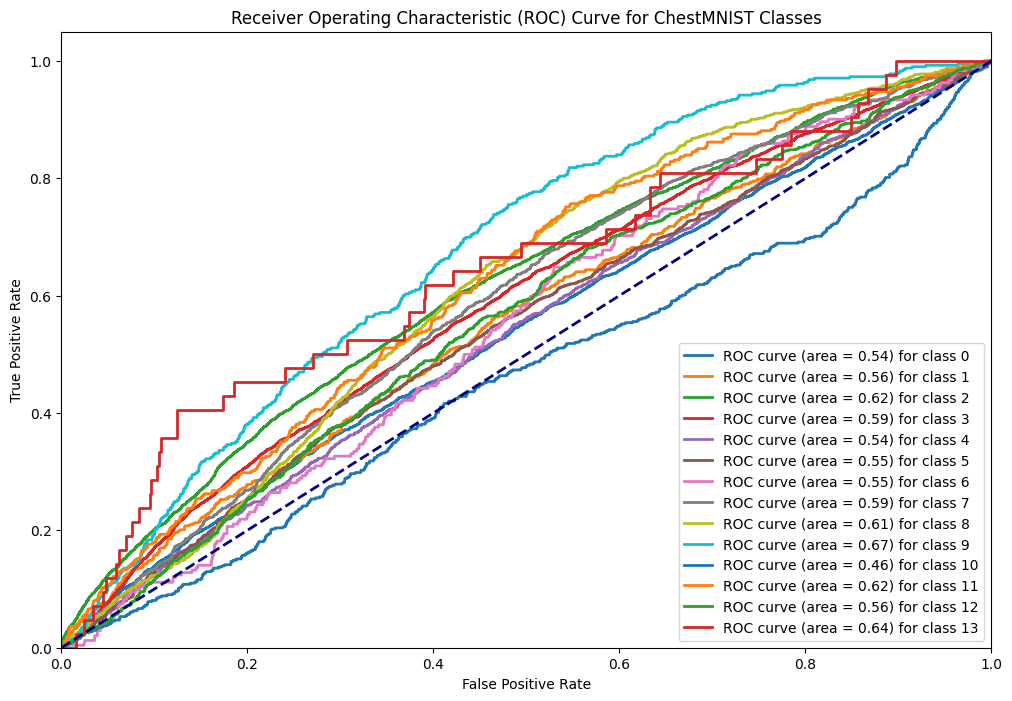

In [ ]:
tprs = []
fprs = []

plt.figure(figsize=(12, 8))
for i in range(14):
    #print(i)
    y_true = []
    y_scores = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted_probs = torch.sigmoid(outputs)
            y_true.extend(labels[:, i].tolist())
            y_scores.extend(predicted_probs[:, i].tolist())
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc, i))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for ChestMNIST Classes')
plt.legend(loc="lower right")
plt.show()
